## Theoretical Justification for Sample Sizes (PAC Learning Bounds)

To determine the minimum sample size ($N$) required to guarantee a **5% error margin ($\epsilon = 0.05$)** with **95% confidence ($\delta = 0.05$)**, we used the following theoretical bounds.

### 1. Logistic Regression (VC Dimension Bound)
For linear classifiers, the sample complexity depends on the number of features ($d=22$).

$$N \approx \frac{d + \ln(1/\delta)}{\epsilon}$$

**Calculation:**
$$N = \frac{22 + \ln(1/0.05)}{0.05} = \frac{22 + 2.99}{0.05} \approx \mathbf{499 \text{ samples}}$$

### 2. Decision Tree (Generalization Bound)
For non-linear models, the bound depends on the complexity of the tree (number of leaf nodes). We assumed a standard limit of **50 leaf nodes**.

$$N \approx \frac{1}{\epsilon} \left( |Leaves| \cdot \ln(2) + \ln\left(\frac{1}{\delta}\right) \right)$$

**Calculation:**
$$N = \frac{1}{0.05} \left( 50 \cdot 0.693 + 2.99 \right) = 20 \cdot 37.64 \approx \mathbf{753 \text{ samples}}$$

---
*These calculations justify why we tested the model on exactly 499 and 753 samples—to empirically validate if the theoretical minimum is sufficient.*

In [1]:
import math

# Inputs
d = 22       # Number of features in your dataset
epsilon = 0.05 # 5% Error tolerance
delta = 0.05   # 95% Confidence

# Logistic Regression Sample Size Formula
N_logistic = (d + math.log(1/delta)) / epsilon

print(f"Theoretical Sample Size for Logistic Regression: {int(N_logistic)} samples")

Theoretical Sample Size for Logistic Regression: 499 samples


In [ ]:
import math

# Inputs
epsilon = 0.05
delta = 0.05
tree_leaves = 50

# Decision Tree Sample Size Formula
N_tree = (1/epsilon) * (tree_leaves * math.log(2) + math.log(1/delta))

print(f"Theoretical Sample Size for Decision Tree: {int(N_tree)} samples")

Theoretical Sample Size for Decision Tree: 753 samples


In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

# --- 1. Load and Preprocess (Standard Steps) ---
raw_data = pd.read_csv('weatherAUS.csv')

df = raw_data.copy()
# Date -> Month
df['Date'] = pd.to_datetime(df['Date']).dt.month
# Drop missing target
df = df.dropna(subset=['RainTomorrow'])

# Features & Target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Identify types
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

# Impute
X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

# Encode Categorical
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# Encode Target
y = le.fit_transform(y)

# Normalize Numerical Features (Important for Logistic Regression!)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
print("DataSet SIZE: ", X.shape)
# Split Train/Test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Full Train Size: {X_train_full.shape[0]}")
print("-" * 60)

# --- 2. Calculate Leverage Scores ---
print("Calculating Leverage Scores...")
X_mat = X_train_full.values
# Add intercept column
X_intercept = np.hstack([np.ones((X_mat.shape[0], 1)), X_mat])

# Compute (X^T X)^-1
XtX_inv = np.linalg.pinv(X_intercept.T @ X_intercept)

# Leverage Scores: sum((X * M) . X)
lev_scores = (X_intercept @ XtX_inv * X_intercept).sum(axis=1)
probs = lev_scores / lev_scores.sum()

print("Leverage Scores Ready.")
print("-" * 60)

# --- 3. Run Experiments (Theoretical vs 5% vs 10%) ---
# Define the experiment configs
configs = [
    {'name': 'Small Subsample (100)', 'n_samples': 100},
    {'name': 'Theoretical (499)', 'n_samples': 499},
    {'name': '5% Scale',          'n_samples': int(0.05 * len(X_train_full))},
    {'name': '10% Scale',         'n_samples': int(0.10 * len(X_train_full))},
    {'name': '100% Scale',         'n_samples': int(1 * len(X_train_full))}
]

results = []

for config in configs:
    n = config['n_samples']
    
    # A. Weighted Sampling
    indices = np.random.choice(
        np.arange(len(X_train_full)), 
        size=n, 
        replace=False, 
        p=probs
    )
    
    X_sub = X_train_full.iloc[indices]
    y_sub = y_train_full[indices]
    
    # B. Calculate Weights (Inverse Probability)
    weights = 1.0 / probs[indices]
    weights = weights / weights.mean() # Normalize
    
    # C. Train Logistic Regression
    model = LogisticRegression(max_iter=3000, random_state=42)
    
    start = time.time()
    model.fit(X_sub, y_sub, sample_weight=weights)
    elapsed = time.time() - start
    
    # D. Evaluate
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Scenario': config['name'],
        'Samples': n,
        'Time (s)': round(elapsed, 4),
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4),
        'Recall': round(recall, 4)
    })

# --- 4. Display Results ---
results_df = pd.DataFrame(results)
print("\nPHASE 1: LOGISTIC REGRESSION RESULTS (Leverage Sampling)")
print(results_df)

DataSet SIZE:  (142193, 22)
Full Train Size: 113754
------------------------------------------------------------
Calculating Leverage Scores...
Leverage Scores Ready.
------------------------------------------------------------

PHASE 1: LOGISTIC REGRESSION RESULTS (Leverage Sampling)
                Scenario  Samples  Time (s)  Accuracy  F1 Score  Recall
0  Small Subsample (100)      100    0.1000    0.7948    0.7830  0.7948
1      Theoretical (499)      499    0.0951    0.8259    0.8174  0.8259
2               5% Scale     5687    0.2190    0.8393    0.8287  0.8393
3              10% Scale    11375    0.6761    0.8385    0.8266  0.8385
4             100% Scale   113754    3.7086    0.8390    0.8287  0.8390


In [4]:
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

# --- Phase 2: DECISION TREE EXPERIMENTS ---

# We assume 'X_train_full', 'y_train_full', 'X_test', 'y_test', and 'probs' (Leverage Probabilities)
# are already defined from Phase 1. If not, re-run the Phase 1 setup block.

print("-" * 60)
print("PHASE 2: DECISION TREE (Leverage Sampling)")
print("-" * 60)

# Define the experiment configs for Tree
# Note: Theoretical Minimum for Tree was calculated as ~753
configs_tree = [
    {'name': 'Small Subsample (100)', 'n_samples': 100},
    {'name': 'Theoretical (753)', 'n_samples': 753},
    {'name': '5% Scale',          'n_samples': int(0.05 * len(X_train_full))},
    {'name': '10% Scale',         'n_samples': int(0.10 * len(X_train_full))},
    {'name': '100% Scale',         'n_samples': int(1 * len(X_train_full))}
]

results_tree = []

for config in configs_tree:
    n = config['n_samples']
    
    # A. Weighted Sampling (Using same Leverage Scores)
    indices = np.random.choice(
        np.arange(len(X_train_full)), 
        size=n, 
        replace=False, 
        p=probs
    )
    
    X_sub = X_train_full.iloc[indices]
    y_sub = y_train_full[indices]
    
    # B. Calculate Weights (Inverse Probability)
    weights = 1.0 / probs[indices]
    weights = weights / weights.mean() # Normalize
    
    # C. Train Decision Tree
    # We limit depth slightly to prevent overfitting on small samples, 
    # but strictly speaking, vanilla Decision Tree is fine too.
    model = DecisionTreeClassifier(random_state=42, max_depth=10) 
    
    start = time.time()
    model.fit(X_sub, y_sub, sample_weight=weights)
    elapsed = time.time() - start
    
    # D. Evaluate
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    results_tree.append({
        'Scenario': config['name'],
        'Samples': n,
        'Time (s)': round(elapsed, 4),
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4),
        'Recall': round(recall, 4)
    })

# --- Display Results ---
results_tree_df = pd.DataFrame(results_tree)
print(results_tree_df)

------------------------------------------------------------
PHASE 2: DECISION TREE (Leverage Sampling)
------------------------------------------------------------
                Scenario  Samples  Time (s)  Accuracy  F1 Score  Recall
0  Small Subsample (100)      100    0.0069    0.7185    0.7272  0.7185
1      Theoretical (753)      753    0.0106    0.7749    0.7752  0.7749
2               5% Scale     5687    0.0507    0.7978    0.7919  0.7978
3              10% Scale    11375    0.0975    0.8169    0.8101  0.8169
4             100% Scale   113754    1.8458    0.8346    0.8232  0.8346


Data prepared successfully. Now you can run the plotting cells.


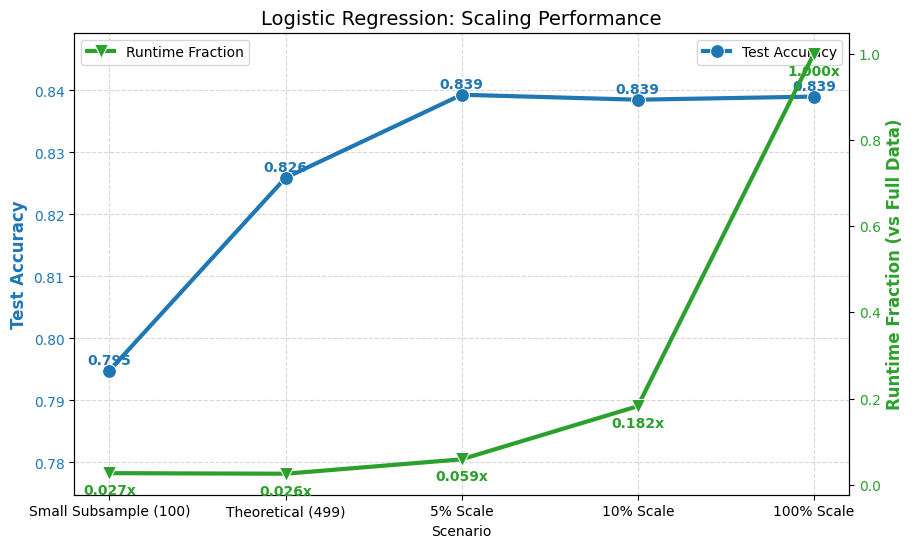

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- RUN THIS BLOCK BEFORE PLOTTING ---

# 1. Define the missing function
def add_time_fraction(df):
    # Find the row with the maximum samples (The '100% Scale' or 'Full Data' row)
    # We assume the largest sample size corresponds to the Full Dataset
    max_samples_idx = df['Samples'].idxmax()
    full_time = df.loc[max_samples_idx, 'Time (s)']
    
    # Calculate fraction: Time_i / Time_Full
    df['Time Fraction'] = df['Time (s)'] / full_time
    return df

# 2. Prepare the DataFrames
# (We take the results_df you created in Phase 1 and Phase 2)
# Ensure you have run Phase 1 and Phase 2 cells first!
df_log = results_df.copy()       # Logistic Regression Results
df_tree = results_tree_df.copy() # Decision Tree Results

# 3. Create the '_frac' DataFrames needed for plotting
df_log_frac = add_time_fraction(df_log)
df_tree_frac = add_time_fraction(df_tree)

print("Data prepared successfully. Now you can run the plotting cells.")
# Ensure data is sorted
df_log_plot = df_log_frac.sort_values('Samples').copy()

# Create a standalone figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Line 1: Accuracy (Left Axis) ---
color_acc = 'tab:blue'
sns.lineplot(x='Scenario', y='Accuracy', data=df_log_plot, ax=ax1, 
             color=color_acc, marker='o', markersize=10, linewidth=3, label='Test Accuracy')

ax1.set_ylabel('Test Accuracy', color=color_acc, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_acc)
# Dynamic limits with buffer
ax1.set_ylim(df_log_plot['Accuracy'].min() - 0.02, df_log_plot['Accuracy'].max() + 0.01)
ax1.grid(True, linestyle='--', alpha=0.5)

# Add Accuracy Labels
for i in range(len(df_log_plot)):
    row = df_log_plot.iloc[i]
    ax1.text(i, row['Accuracy'] + 0.001, f"{row['Accuracy']:.3f}", 
             color=color_acc, ha="center", fontweight='bold')

# --- Line 2: Runtime Fraction (Right Axis) ---
ax2 = ax1.twinx()
color_frac = 'tab:green'
sns.lineplot(x='Scenario', y='Time Fraction', data=df_log_plot, ax=ax2, 
             color=color_frac, marker='v', markersize=10, linewidth=3, linestyle='-', label='Runtime Fraction')

ax2.set_ylabel('Runtime Fraction (vs Full Data)', color=color_frac, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_frac)

# Add Fraction Labels
for i in range(len(df_log_plot)):
    row = df_log_plot.iloc[i]
    ax2.text(i, row['Time Fraction'] - 0.05, f"{row['Time Fraction']:.3f}x", 
             color=color_frac, ha="center", fontweight='bold')

plt.title('Logistic Regression: Scaling Performance', fontsize=14)
plt.xlabel('Dataset Size', fontsize=12)
plt.show()

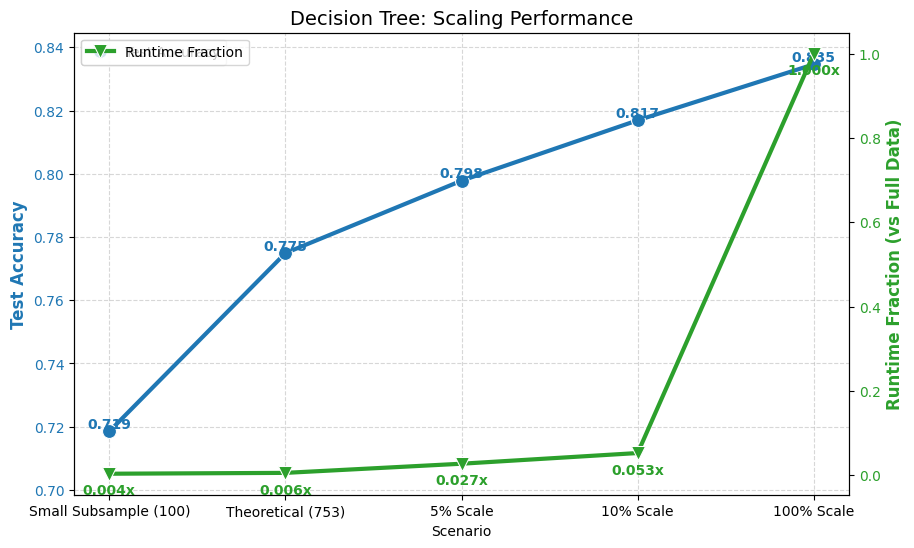

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure data is sorted
df_tree_plot = df_tree_frac.sort_values('Samples').copy()

# Create a standalone figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Line 1: Accuracy (Left Axis) ---
color_acc = 'tab:blue'
sns.lineplot(x='Scenario', y='Accuracy', data=df_tree_plot, ax=ax1, 
             color=color_acc, marker='o', markersize=10, linewidth=3, label='Test Accuracy')

ax1.set_ylabel('Test Accuracy', color=color_acc, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_acc)
# Dynamic limits with buffer
ax1.set_ylim(df_tree_plot['Accuracy'].min() - 0.02, df_tree_plot['Accuracy'].max() + 0.01)
ax1.grid(True, linestyle='--', alpha=0.5)

# Add Accuracy Labels
for i in range(len(df_tree_plot)):
    row = df_tree_plot.iloc[i]
    ax1.text(i, row['Accuracy'] + 0.001, f"{row['Accuracy']:.3f}", 
             color=color_acc, ha="center", fontweight='bold')

# --- Line 2: Runtime Fraction (Right Axis) ---
ax2 = ax1.twinx()
color_frac = 'tab:green'
sns.lineplot(x='Scenario', y='Time Fraction', data=df_tree_plot, ax=ax2, 
             color=color_frac, marker='v', markersize=10, linewidth=3, linestyle='-', label='Runtime Fraction')

ax2.set_ylabel('Runtime Fraction (vs Full Data)', color=color_frac, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_frac)

# Add Fraction Labels
for i in range(len(df_tree_plot)):
    row = df_tree_plot.iloc[i]
    ax2.text(i, row['Time Fraction'] - 0.05, f"{row['Time Fraction']:.3f}x", 
             color=color_frac, ha="center", fontweight='bold')

plt.title('Decision Tree: Scaling Performance', fontsize=14)
plt.xlabel('Dataset Size', fontsize=12)
plt.show()